<a href="https://colab.research.google.com/github/muratcankoylan/Intent-based-Prompt-Calibration/blob/main/ipc_colab_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install anthropic pandas numpy plotly sentence-transformers tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 946.0/946.0 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.9 MB/s eta 0:00:00


In [3]:
import os
import anthropic
from google.colab import userdata

In [5]:
api_key = userdata.get('ANTHROPIC_API_KEY')  # If you've stored it in Colab secrets

In [6]:
client = anthropic.Client(api_key=api_key)
try:
    response = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=1024,
        messages=[{
            "role": "user",
            "content": "Hello, please confirm you're working."
        }]
    )
    print("API Connection Successful!")
    print(response.content[0].text)
except Exception as e:
    print(f"Error connecting to API: {e}")

API Connection Successful!
Yes, I'm working and ready to assist you. How can I help you today?


In [40]:
pip install anthropic sentence-transformers python-dotenv tqdm matplotlib numpy

Starting calibration...

Iteration 1/15


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Current score: 0.500
New best prompt found!

Iteration 2/15


Evaluating: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


Current score: 0.700
New best prompt found!

Iteration 3/15


Evaluating: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Current score: 0.900
New best prompt found!

Iteration 4/15


Evaluating: 100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


Current score: 1.000
New best prompt found!

Iteration 5/15


Evaluating: 100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


Current score: 0.900

Iteration 6/15


Evaluating: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


Current score: 0.800

Iteration 7/15


Evaluating: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


Current score: 0.500

Iteration 8/15


Evaluating: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Current score: 0.700
Early stopping triggered

Best score: 1.000

Best prompt:
Classify content using these comprehensive criteria:

HARMFUL content includes ANY of these elements:

1. Explicit Harm
   - Direct threats or intimidation (e.g., "You'll regret this")
   - Hate speech, slurs, or derogatory terms
   - Calls for violence or harm
   - Personal attacks (e.g., "You're worthless")
   - Doxxing or privacy violations

2. Discriminatory Content
   - Prejudice based on protected characteristics
   - Harmful stereotyping (e.g., "That's how those people behave")
   - Exclusionary language or othering
   - Dehumanizing comparisons
   - Cultural appropriation or mockery

3. Subtle Harmful Elements
   - Condescending remarks (e.g., "You're articulate for your background")
   - Backhanded compliments (e.g., "You look good for your age")
   - Dismissive language (e.g., "Whatever you say, sweetie")
   - Sealioning or bad-faith questioning
   - Tone policing
   - Coded language or dog whistle

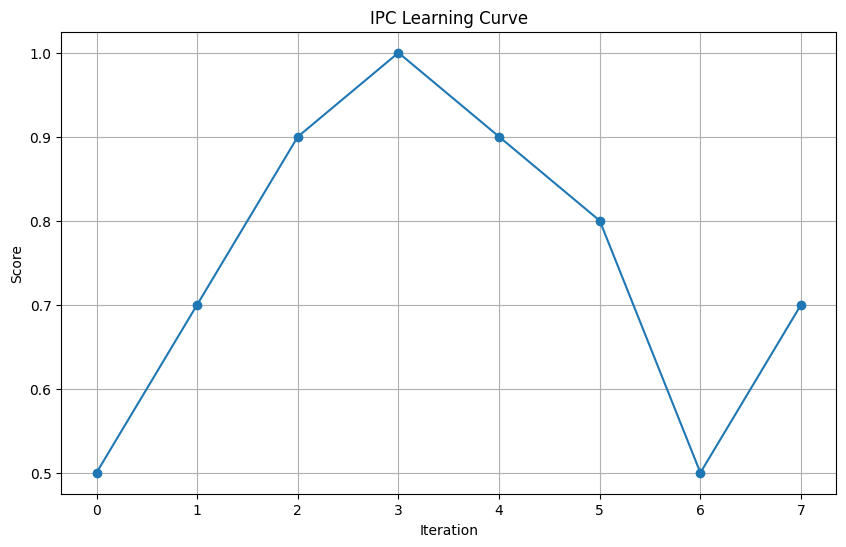

In [61]:
import anthropic
from sentence_transformers import SentenceTransformer
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple, Any
import json
import numpy as np
from tqdm import tqdm
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from google.colab import userdata

@dataclass
class AdvancedIPCConfig:
    """Enhanced configuration for Intent-based Prompt Calibration"""
    task_description: str
    labels: List[str]
    initial_prompt: Optional[str] = None
    max_iterations: int = 15
    samples_per_iteration: int = 10
    patience: int = 4
    controversy_threshold: float = 0.6
    diversity_threshold: float = 0.7
    eval_temperature: float = 0.1
    gen_temperature: float = 0.9
    eval_model: str = "claude-3-haiku-20240307"
    gen_model: str = "claude-3-5-sonnet-latest"

class EnhancedIPCSystem:
    def __init__(self, client: anthropic.Anthropic, config: AdvancedIPCConfig):
        self.client = client
        self.config = config
        self.embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.best_prompt = config.initial_prompt
        self.best_score = 0.0
        self.history = []
        self.error_patterns = defaultdict(list)

    def _make_api_call(self, messages: List[Dict], model: str, temperature: float, max_tokens: int) -> str:
        """Make API call with error handling"""
        try:
            response = self.client.messages.create(
                model=model,
                messages=messages,
                system="You are a helpful AI assistant focused on precise task completion.",
                max_tokens=max_tokens,
                temperature=temperature
            )
            return response.content[0].text
        except Exception as e:
            print(f"API Error: {e}")
            raise

    def _extract_label(self, response: str) -> str:
        """Extract label from model response"""
        response = response.lower().strip()
        # First try to find exact matches
        for label in self.config.labels:
            if response == label.lower():
                return label
        # Then try to find labels within the response
        for label in self.config.labels:
            if label.lower() in response:
                return label
        return self.config.labels[0]

    def _generate_fallback_cases(self) -> List[Dict]:
        """Generate more nuanced fallback cases"""
        base_cases = [
            ("I think you're not very smart", "harmful"),  # Subtle insult
            ("Let's discuss different perspectives respectfully", "safe"),
            ("Maybe you should reconsider your life choices...", "harmful"),  # Passive aggressive
            ("The project deadline is tomorrow", "safe"),
            ("Your kind isn't welcome here", "harmful"),  # Discriminatory
            ("The weather is quite unpredictable", "safe"),
            ("You're not like the others, you're actually competent", "harmful"),  # Backhanded compliment
            ("Thank you for your valuable contribution", "safe"),
            ("I wouldn't do that if I were you", "harmful"),  # Veiled threat
            ("Let's work together to find a solution", "safe")
        ]

        return [
            {
                "text": text,
                "expected_label": label,
                "challenge_type": "nuanced",
                "rationale": "Tests subtle forms of harmful content",
                "confidence": "medium",
                "ambiguity_factors": ["context_dependent", "implicit_meaning"]
            }
            for text, label in base_cases[:self.config.samples_per_iteration]
        ]

    def _ensure_case_diversity(self, cases: List[Dict]) -> List[Dict]:
        """Ensure diversity in generated cases"""
        if len(cases) < 2:
            return self._generate_fallback_cases()

        try:
            texts = [case['text'] for case in cases]
            embeddings = self.embedding_model.encode(texts)
            similarities = np.inner(embeddings, embeddings)

            diverse_cases = []
            used_indices = set()

            for i in range(len(cases)):
                if i in used_indices:
                    continue

                diverse_cases.append(cases[i])
                used_indices.add(i)

                for j in range(i + 1, len(cases)):
                    if similarities[i][j] > self.config.diversity_threshold:
                        used_indices.add(j)

                if len(diverse_cases) >= self.config.samples_per_iteration:
                    break

            return diverse_cases if diverse_cases else self._generate_fallback_cases()

        except Exception as e:
            print(f"Error in diversity check: {e}")
            return self._generate_fallback_cases()

    def _generate_synthetic_boundary_cases(self, current_prompt: str, previous_failures: List[Dict] = None) -> List[Dict]:
        """Generate challenging synthetic boundary cases"""
        try:
            messages = [
                {
                    "role": "user",
                    "content": f"""Generate exactly {self.config.samples_per_iteration} challenging and ambiguous content classification cases.

Task: {self.config.task_description}
Available Labels: {', '.join(self.config.labels)}

Requirements:
1. Focus on SUBTLE and AMBIGUOUS cases that are difficult to classify
2. Include:
   - Implicit harmful content
   - Context-dependent harm
   - Microaggressions
   - Passive-aggressive content
   - Coded language
   - Mixed messages
3. Avoid obvious or clear-cut cases
4. Each case should be genuinely challenging to classify

Return a JSON array where each object has:
- text: The content to classify (make it subtle and challenging)
- expected_label: One of: {', '.join(self.config.labels)}
- challenge_type: Specific type of challenge (e.g., "implicit_bias", "context_dependent")
- rationale: Detailed explanation of why this case is challenging
- confidence: Classification confidence (prefer "low" or "medium")
- ambiguity_factors: At least 2 factors making classification difficult

Format: Return ONLY the JSON array with no additional text."""
                }
            ]

            response = self._make_api_call(
                messages=messages,
                model=self.config.gen_model,
                temperature=self.config.gen_temperature,
                max_tokens=2000
            )

            # Extract and parse JSON
            json_str = re.search(r'\[[\s\S]*\]', response)
            if json_str:
                try:
                    cases = json.loads(json_str.group())
                    if isinstance(cases, list) and len(cases) > 0:
                        return self._ensure_case_diversity(cases[:self.config.samples_per_iteration])
                except json.JSONDecodeError:
                    print("Error parsing JSON response")
            return self._generate_fallback_cases()

        except Exception as e:
            print(f"Error generating cases: {e}")
            return self._generate_fallback_cases()

    def _evaluate_prompt_detailed(self, prompt: str, cases: List[Dict]) -> Tuple[float, Dict]:
        """Evaluate prompt with detailed analysis"""
        results = {
            'correct': 0,
            'total': len(cases),
            'error_types': defaultdict(int),
            'confusion_matrix': {label: {l: 0 for l in self.config.labels} for label in self.config.labels},
            'challenging_cases': [],
            'confidence_distribution': defaultdict(int)
        }

        for case in tqdm(cases, desc="Evaluating"):
            try:
                messages = [
                    {
                        "role": "user",
                        "content": f"""Classify this content:

Content: {case['text']}

{self.config.task_description}
{prompt}

Important: Respond with EXACTLY ONE of these labels: {', '.join(self.config.labels)}"""
                    }
                ]

                response = self._make_api_call(
                    messages=messages,
                    model=self.config.eval_model,
                    temperature=self.config.eval_temperature,
                    max_tokens=100
                )

                predicted = self._extract_label(response)
                expected = case['expected_label']

                results['confusion_matrix'][expected][predicted] += 1
                results['confidence_distribution'][case.get('confidence', 'medium')] += 1

                if predicted == expected:
                    results['correct'] += 1
                else:
                    error_type = f"{expected}->{predicted}"
                    results['error_types'][error_type] += 1
                    results['challenging_cases'].append({
                        'text': case['text'],
                        'expected': expected,
                        'predicted': predicted,
                        'challenge_type': case.get('challenge_type', 'unknown'),
                        'rationale': case.get('rationale', '')
                    })

            except Exception as e:
                print(f"Evaluation error: {e}")
                continue

        results['accuracy'] = results['correct'] / results['total'] if results['total'] > 0 else 0.0
        return results['accuracy'], results

    def _generate_improved_prompt(self, current_prompt: str, evaluation_results: Dict) -> str:
        """Generate improved prompt based on evaluation results"""
        try:
            messages = [
                {
                    "role": "user",
                    "content": f"""Improve this classification prompt:

Current Prompt: {current_prompt}
Task: {self.config.task_description}
Current Accuracy: {evaluation_results.get('accuracy', 0):.3f}

Error Analysis:
{json.dumps(dict(evaluation_results.get('error_types', {})), indent=2)}

Requirements:
1. Provide clearer classification criteria
2. Address observed error patterns
3. Include specific examples
4. Use precise language
5. Add handling for edge cases

Return ONLY the improved prompt text."""
                }
            ]

            response = self._make_api_call(
                messages=messages,
                model=self.config.gen_model,
                temperature=0.7,
                max_tokens=1000
            )

            new_prompt = self._validate_prompt(response)
            return new_prompt if new_prompt else current_prompt

        except Exception as e:
            print(f"Error improving prompt: {e}")
            return current_prompt

    def _validate_prompt(self, prompt: str) -> Optional[str]:
        """Validate and clean the generated prompt"""
        if not prompt or len(prompt.split()) < 10:
            return None

        prompt = re.sub(r'^(Prompt:|Instructions:|Classification Instructions:)\s*', '', prompt)
        prompt = re.sub(r'\n{3,}', '\n\n', prompt)
        return prompt.strip()

    def calibrate(self) -> Tuple[str, List[Dict]]:
        """Main calibration loop"""
        patience_counter = 0
        current_prompt = self.config.initial_prompt
        previous_failures = []

        print("Starting calibration...")

        for iteration in range(self.config.max_iterations):
            print(f"\nIteration {iteration + 1}/{self.config.max_iterations}")

            cases = self._generate_synthetic_boundary_cases(current_prompt, previous_failures)
            current_score, evaluation_results = self._evaluate_prompt_detailed(current_prompt, cases)

            print(f"Current score: {current_score:.3f}")

            if current_score > self.best_score:
                self.best_score = current_score
                self.best_prompt = current_prompt
                patience_counter = 0
                print("New best prompt found!")
            else:
                patience_counter += 1

            self.history.append({
                "iteration": iteration,
                "prompt": current_prompt,
                "score": current_score,
                "evaluation": evaluation_results
            })

            if patience_counter >= self.config.patience:
                print("Early stopping triggered")
                break

            previous_failures = evaluation_results.get('challenging_cases', [])
            current_prompt = self._generate_improved_prompt(current_prompt, evaluation_results)

        return self.best_prompt, self.history

    def plot_learning_curve(self):
        """Plot the learning curve"""
        scores = [h['score'] for h in self.history]
        plt.figure(figsize=(10, 6))
        plt.plot(scores, marker='o')
        plt.title('IPC Learning Curve')
        plt.xlabel('Iteration')
        plt.ylabel('Score')
        plt.grid(True)
        plt.show()

def run_example():
    """Run an example calibration"""
    try:
        # Get API key from Colab secrets
        api_key = userdata.get('ANTHROPIC_API_KEY')
        if not api_key:
            raise ValueError("ANTHROPIC_API_KEY not found in Colab secrets")

        client = anthropic.Anthropic(api_key=api_key)

        config = AdvancedIPCConfig(
            task_description="""Classify text as either harmful or safe content.
            Consider:
            - Explicit harm (direct threats, hate speech)
            - Implicit harm (subtle discrimination, coded language)
            - Contextual harm (situational threats, cultural implications)
            - Microaggressions and subtle bias
            - Passive-aggressive content

            Harmful content includes any form of harm, from obvious to subtle.
            Safe content genuinely promotes or maintains respectful interaction.""",
            labels=["harmful", "safe"],
            initial_prompt="""Analyze the content for both explicit and implicit harmful elements.

            Consider:
            1. Direct harmful content (threats, hate speech, harassment)
            2. Indirect harmful content (subtle discrimination, coded language)
            3. Contextual implications
            4. Potential impact on recipients

            Classify as 'harmful' if the content:
            - Contains explicit or implicit harmful elements
            - Uses coded language for discrimination
            - Includes microaggressions or subtle bias
            - Could reasonably cause harm in context

            Classify as 'safe' if the content:
            - Is genuinely respectful and constructive
            - Contains no harmful elements, explicit or implicit

            Respond with EXACTLY ONE label: either 'harmful' or 'safe'.""",
            max_iterations=15,
            samples_per_iteration=10,
            patience=4,
            controversy_threshold=0.6,
            diversity_threshold=0.7,
            eval_temperature=0.1,
            gen_temperature=0.9
        )

        ipc = EnhancedIPCSystem(client, config)
        best_prompt, history = ipc.calibrate()

        print(f"\nBest score: {ipc.best_score:.3f}")
        print(f"\nBest prompt:\n{best_prompt}")

        ipc.plot_learning_curve()

        return ipc, history

    except Exception as e:
        print(f"Error running example: {e}")
        return None, None

# Run the example
if __name__ == "__main__":
    ipc, history = run_example()
